<a href="https://colab.research.google.com/github/nasarar/Post_Covid19_Vacation_Projection/blob/Joseph/covid_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
# for later versions:
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

In [18]:
!gdown --id "14Tt_SmtnM1OiOtXxcQIs8O2W_aNlAIgR" -O "covid.csv"

Downloading...
From: https://drive.google.com/uc?id=14Tt_SmtnM1OiOtXxcQIs8O2W_aNlAIgR
To: /content/covid.csv
22.8MB [00:00, 72.7MB/s]


In [19]:
import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
import pandas as pd

In [20]:
df = pd.read_csv('/content/covid.csv')
df.location

0        Afghanistan
1        Afghanistan
2        Afghanistan
3        Afghanistan
4        Afghanistan
            ...     
87945       Zimbabwe
87946       Zimbabwe
87947       Zimbabwe
87948       Zimbabwe
87949       Zimbabwe
Name: location, Length: 87950, dtype: object

In [21]:
country_list = df.iso_code.value_counts().keys()
country_list

Index(['ARG', 'MEX', 'THA', 'PER', 'TWN', 'KOR', 'USA', 'JPN', 'OWID_NAM',
       'CHN',
       ...
       'MSR', 'FLK', 'SHN', 'WLF', 'JEY', 'CUW', 'ABW', 'NRU', 'TON', 'TUV'],
      dtype='object', length=223)

Epoch 1/15
36/36 [==============================] - 2s 9ms/step - loss: 1399.1140 - val_loss: 4932.6714
Epoch 2/15
36/36 [==============================] - 0s 2ms/step - loss: 1318.7138 - val_loss: 3242.2507
Epoch 3/15
36/36 [==============================] - 0s 3ms/step - loss: 589.3804 - val_loss: 287.8058
Epoch 4/15
36/36 [==============================] - 0s 3ms/step - loss: 47.8840 - val_loss: 42.8655
Epoch 5/15
36/36 [==============================] - 0s 3ms/step - loss: 7.1647 - val_loss: 7.4585
Epoch 6/15
36/36 [==============================] - 0s 3ms/step - loss: 5.4165 - val_loss: 9.2153
Epoch 7/15
36/36 [==============================] - 0s 3ms/step - loss: 4.6153 - val_loss: 9.0834
Epoch 8/15
36/36 [==============================] - 0s 3ms/step - loss: 4.3194 - val_loss: 7.6124
Epoch 9/15
36/36 [==============================] - 0s 3ms/step - loss: 3.7653 - val_loss: 7.6570
Epoch 10/15
36/36 [==============================] - 0s 3ms/step - loss: 3.5020 - val_loss: 6.0155
E

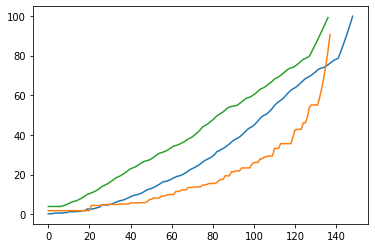

In [22]:
country_list = ["USA","ISL","GBR"]
for country in country_list:
  df1 = df[df.iso_code==country].copy()
  df1.reset_index(inplace=True)
  start = 0
  for i in range(len(df1.total_vaccinations_per_hundred)):
    if df1.total_vaccinations_per_hundred[i] >0:
      start = i
      break
  df1.total_vaccinations_per_hundred.fillna(inplace= True,method='backfill')
  data = np.array(df1['total_vaccinations_per_hundred'][start:-1])
  # print(len(data))
  #data prep
  frame = 1
  y = []
  x = []
  for i in range(len(data)-frame):
    x.append(data[i:i+frame])
    y.append(data[i + frame])

  test_size = 1
  x = np.array(x)
  x = np.expand_dims(x,-1)
  y = np.array(y)

  #model definition train and fit
  model = tf.keras.Sequential()
  model.add(tf.keras.Input(shape=(x.shape[1],1,)))
  # model.add(tf.keras.layers.Dense(64,activation='relu'))
  model.add(tf.keras.layers.LSTM(32,activation='relu'))
  # model.add(tf.keras.layers.LSTM(16,activation='relu'))
  model.add(tf.keras.layers.Dense(1,activation='relu'))
  model.compile(optimizer='adam',loss = tf.keras.losses.MeanSquaredError())
  history = model.fit(x[:-test_size],y[:-test_size],epochs=15,verbose=1,batch_size=4,validation_data=(x[-test_size:],y[-test_size:]))
  datetime.datetime.now() + datetime.timedelta(days=1)
  d = list(df1.date[start+frame:-1])
  for i in range((12*30)):
    # print(list(df1.date[:-1]))
    date = parse(d[-1]) + datetime.timedelta(days=1)
    
    # print(str(date).split()[0])
    x_pred = y[-frame:]
    x_pred = np.expand_dims(x_pred,0)
    x_pred = np.expand_dims(x_pred,-1)
    # print(y[-frame:],x_pred,x_pred.shape)
    y_pred = model.predict(x_pred)
    y_pred = np.round(y_pred,2)
    if y_pred>100:
      break
    y = np.append(y,y_pred)
    d.append(str(date).split()[0])
  dfp = pd.DataFrame()
  dfp['date'] = d
  dfp['total_vaccinations_per_hundred'] = y
  dfp.to_csv(f'{country}_predictions.csv')

  plt.plot(y)


In [15]:
dfp

,date,total_vaccinations_per_hundred
0,2021-01-04,3.940000
1,2021-01-05,3.940000
2,2021-01-06,3.940000
3,2021-01-07,3.940000
4,2021-01-08,3.940000
...,...,...
132,2021-05-16,90.180000
133,2021-05-17,92.379997
134,2021-05-18,94.620003
135,2021-05-19,96.889999
